In [47]:
import torch
import parameters_will
import torch.optim as optim
import RNN_Will as _model_
import numpy as np
import matplotlib.pyplot as plt
import pickle
import utils

%load_ext autoreload
%autoreload 2

# Set up our parameters
params = parameters_will.default_params()
params.model.h_size = 20
params.data.min_beats = 1
params.data.max_beats = 2
params.data.batch_size = 7
params.model.batch_size

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Num jitters does not equal batch size!


Text(0.5, 1.0, 'RNN or Not')

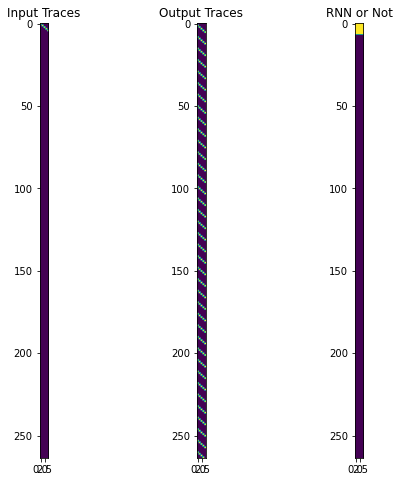

In [56]:
input_dict = utils.generate_data(params, freqs = np.full(params.data.batch_size, 7, dtype=int), jitter = np.arange(7))
plt.figure(figsize = (8,8))
plt.subplot(1,3,1)
plt.imshow(input_dict.observation)
plt.title('Input Traces')

plt.subplot(1,3,2)
plt.imshow(input_dict.outputs)
plt.title('Output Traces')

plt.subplot(1,3,3)
plt.imshow(input_dict.input_or_rnn)
plt.title('RNN or Not')

In [57]:
params.train.train_iters = 100000
print_iters = 100
reinitialise = 0

if reinitialise:
    # make instance of model
    model = _model_.VanillaRNN(params.model)
    # put model to gpu (if available)
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Make an ADAM optimizer
    optimizer = optim.Adam(model.parameters(), lr=params.train.learning_rate, weight_decay=params.train.weight_decay)
else:
    model.batch_size = params.data.batch_size

min_loss = np.infty

for train_i in range(params.train.train_iters):

    # 1. Get input data, and convert to tensors (I have assumed you will put inputs etc into a dictionary)
    input_dict = utils.generate_data(params, freqs = np.full(params.data.batch_size, 7, dtype=int))
    
    # set all gradients to None
    # optimizer.zero_grad()
    for param in model.parameters():
        param.grad = None
        
    # forward pass
    variables = model(input_dict, device=device)
    
    # collate inputs for model
    (losses, loss_fit) = _model_.compute_losses_torch(input_dict, variables, model, params.train, device=device)

    # backward pass
    losses.backward()

    # clip gradients (you don't have to do this but it's a good idea for RNNs)
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0, norm_type=2)

    optimizer.step()
    
    if losses.detach() < min_loss:
        min_loss = losses.detach()
        best_model = model
        print(f"{train_i}, new PB! {min_loss}")

    if train_i % print_iters == 0:
        print(f"{train_i}, {losses.item():.5f}, {loss_fit.item():.5f}, {losses.item()-loss_fit.item():.5f}")

0, new PB! 199.00082397460938
0, 199.00082, 198.32999, 0.67084
1, new PB! 60.69878387451172
3, new PB! 57.78754806518555
31, new PB! 56.36974334716797
40, new PB! 47.325218200683594
42, new PB! 44.58612060546875
64, new PB! 40.55418395996094
100, new PB! 31.943389892578125
100, 31.94339, 31.77620, 0.16719
120, new PB! 29.526952743530273
200, 79.68710, 79.42731, 0.25979
300, 129.63116, 129.21896, 0.41220
400, 98.29440, 97.97879, 0.31561
500, 212.62549, 211.90189, 0.72360


KeyboardInterrupt: 

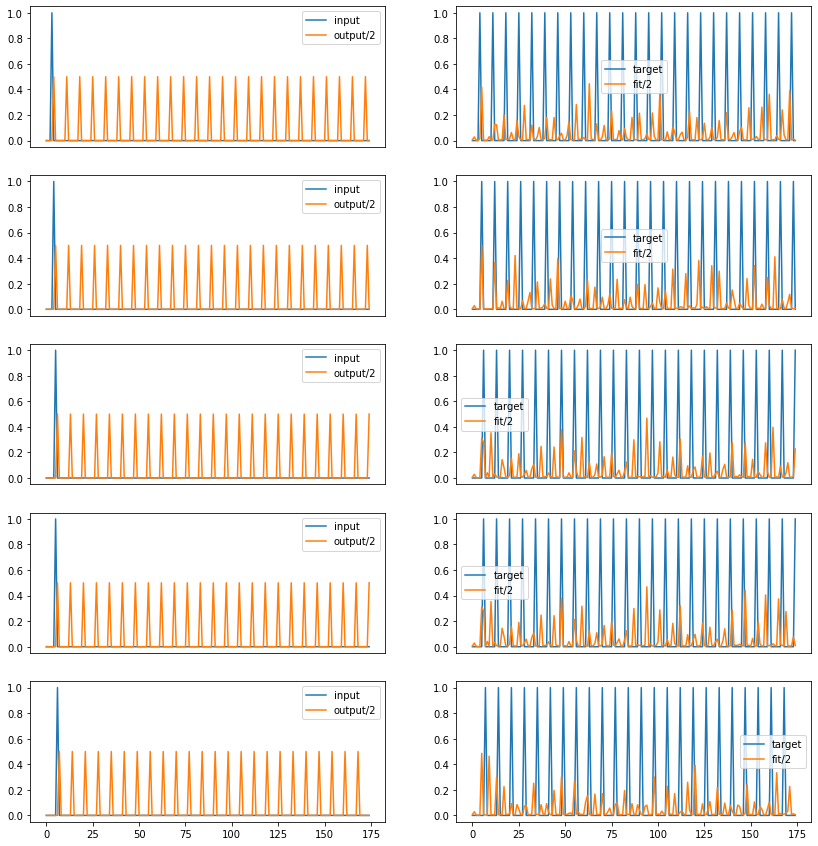

In [58]:
# Let's have a look at how one example is going
use_best = 0
if use_best:
    model_use = best_model
else:
    model_use = model
    
params.model.h_size = 20
params.data.min_beats = 1
params.data.max_beats = 2
input_dict = utils.generate_data(params, freqs = np.full(params.data.batch_size, 7, dtype=int))

variables = model_use(input_dict, device=device)
output = torch.stack(variables.pred)
plt.figure(figsize=(14,3*params.data.batch_size))

for sample in range(params.data.batch_size):
    plt.subplot(params.data.batch_size,2,1+sample*2)
    #plt.title(f'Desired Function, freq = {params.data.freqs[sample]}')
    plt.plot(input_dict.observation[:,sample],label='input')
    plt.plot(0.5*input_dict.outputs[:,sample],label='output/2')
    plt.legend()
    if sample < params.data.batch_size-1:
        plt.xticks([])
        
    plt.subplot(params.data.batch_size,2,2+sample*2)
    #plt.title(f'Network Behaviour, freq = {params.data.freqs[sample]}')
    plt.plot(input_dict.outputs[:,sample], label='target')
    plt.plot(0.5*output.detach().numpy()[:,sample,0], label = 'fit/2')
    plt.legend()
    if sample < params.data.batch_size-1:
        plt.xticks([])